In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tensorflow.keras import Sequential

In [3]:
from tensorflow.python.keras.layers import Dense

In [4]:
#Reading train data
data=pd.read_csv("/content/magic_gamma_telescope04_ (1).csv")

In [5]:
data.shape

(19020, 11)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   flength   19020 non-null  float64
 1   fwidth    19020 non-null  float64
 2   fsize     19020 non-null  float64
 3   fconc     19020 non-null  float64
 4   fconc1    19020 non-null  float64
 5   fsym      19020 non-null  float64
 6   fm3long   19020 non-null  float64
 7   fm3trans  19020 non-null  float64
 8   falpha    19020 non-null  float64
 9   dist      19020 non-null  float64
 10  class     19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


In [7]:
#Checking for missing values
data.isna().sum()

flength     0
fwidth      0
fsize       0
fconc       0
fconc1      0
fsym        0
fm3long     0
fm3trans    0
falpha      0
dist        0
class       0
dtype: int64

In [8]:
data.columns

Index(['flength', 'fwidth', 'fsize', 'fconc', 'fconc1', 'fsym', 'fm3long',
       'fm3trans', 'falpha', 'dist', 'class'],
      dtype='object')

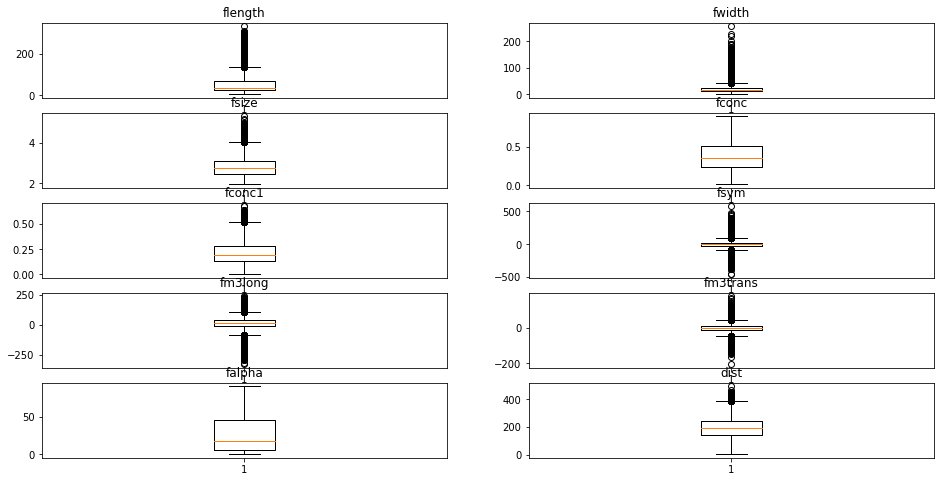

In [9]:
#Checking for outliers
plt.figure(figsize=(16,8))

plt.subplot(5,2,1)
plt.boxplot(data['flength'])
plt.title("flength")

plt.subplot(5,2,2)
plt.boxplot(data['fwidth'])
plt.title("fwidth")

plt.subplot(5,2,3)
plt.boxplot(data['fsize'])
plt.title("fsize")

plt.subplot(5,2,4)
plt.boxplot(data['fconc'])
plt.title("fconc")

plt.subplot(5,2,5)
plt.boxplot(data['fconc1'])
plt.title("fconc1")

plt.subplot(5,2,6)
plt.boxplot(data['fsym'])
plt.title("fsym")

plt.subplot(5,2,7)
plt.boxplot(data['fm3long'])
plt.title("fm3long")

plt.subplot(5,2,8)
plt.boxplot(data['fm3trans'])
plt.title("fm3trans")

plt.subplot(5,2,9)
plt.boxplot(data['falpha'])
plt.title("falpha")

plt.subplot(5,2,10)
plt.boxplot(data['dist'])
plt.title("dist")

plt.show()
    

In [10]:
#Removing Outliers
colum=['flength', 'fwidth', 'fsize', 'fconc', 'fconc1', 'fsym', 'fm3long',
       'fm3trans', 'falpha', 'dist']
for col in colum:
  Q1 = np.percentile(data[col],25,interpolation='midpoint')
  Q2 = np.percentile(data[col],50,interpolation='midpoint')
  Q3 = np.percentile(data[col],75,interpolation='midpoint')
  IQR = Q3-Q1
  low_limit = Q1-1.5*IQR
  upper_limit = Q3+1.5*IQR
  data=data.drop(data.loc[(data[col]>upper_limit)|(data[col]<low_limit)].index)
data.shape

(15035, 11)

In [11]:
data["class"].value_counts()

g    10762
h     4273
Name: class, dtype: int64

In [12]:
data["class"]=data["class"].map({"g":0,"h":1})

In [13]:
#Splitting features and output
X = data.drop(['class'],axis=1)

y = data['class']

In [14]:
from sklearn.preprocessing import StandardScaler
std=StandardScaler()
X=std.fit_transform(X)

In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

In [16]:
from tensorflow.keras.optimizers import SGD
sgd = SGD(lr=0.01, momentum=0.8)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [17]:
n_features=10
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(20, activation="tanh", kernel_initializer='he_normal', input_shape=(n_features,)))
    model.add(Dense(15, activation='tanh', kernel_initializer='he_normal'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(optimizer="sgd", loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:
from keras.wrappers.scikit_learn import KerasClassifier

In [21]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [32]:
from sklearn.model_selection import GridSearchCV

epochs = [10, 50]
batch_size=[5, 10, 20]
param_grid = {"epochs":epochs,"batch_size":batch_size}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring = 'accuracy')
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))



Best: 0.859411 using {'batch_size': 10, 'epochs': 50}


In [33]:
model.fit(X_train,y_train,batch_size=10,epochs=50)

In [34]:
y_pred=model.predict(X_test)
y_pred=np.array(y_pred.flatten(),dtype=float)

94/94 [==============================] - 0s 2ms/step


In [35]:
y_model=(y_pred>0.5).astype(int)

In [36]:
y_model

array([0, 0, 0, ..., 0, 0, 0])

In [37]:
#Checking the accuracy and f1_score
from sklearn.metrics import accuracy_score,f1_score
print(f"accuracy: {accuracy_score( y_test,y_model)}")
print(f"f1_score: {f1_score( y_test,y_model)}")

accuracy: 0.8699700698370469
f1_score: 0.7491982039769083
